In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from celluloid import Camera
from matplotlib.patches import Rectangle, Circle

In [10]:
def f_adjacent(x, p):
    x_right = np.roll(x,1)
    x_left = np.roll(x,-1)

    # ...left: force on i from (i+1)

    x_diff_right = x['x'] - x_right['x'] 
    y_diff_right = x['y'] - x_right['y']
    x_diff_left = x['x'] - x_left['x']
    y_diff_left = x['y'] -x_left['y']

    distances_right = (x_diff_right**2 + y_diff_right**2)**(1/2)
    distances_left = (x_diff_left**2 + y_diff_left**2)**(1/2)

    fx_left = -1 * k * x_diff_left * (1 - l/distances_left) # * stretching
    fy_left = -1 * k * y_diff_left  * (1 - l/distances_left) # * stretching
    fx_right = -1 * k * x_diff_right * (1 - l/distances_right) # * stretching
    fy_right = -1 * k * y_diff_right * (1 - l/distances_right) # * stretching

    if periodic == False:
        fx_left[-1] = 0
        fy_left[-1] = 0
        fx_right[0] = 0
        fy_right[0] = 0

    fx = fx_left + fx_right
    fy = fy_left + fy_right
    if topFixed == True:
        fx[0] = 0
        fy[0] = 0
    return np.array(list(zip(fx, fy)), dtype=[('x', np.float32), ('y', np.float32)])
    

def f_twoadjacent(x, p):
    # forces between every other element
    x_diff2_right = x['x'] - np.roll(x,2)['x'] 
    y_diff2_right = x['y'] - np.roll(x,2)['y']
    x_diff2_left = x['x'] - np.roll(x,-2)['x']
    y_diff2_left = x['y'] - np.roll(x,-2)['y']

    fx2_left = -1 * k2 * x_diff2_left * (1 - 2*l/(x_diff2_left**2 + y_diff2_left**2)**(1/2)) # * stretching
    fy2_left = -1 * k2 * y_diff2_left  * (1 - 2*l/(x_diff2_left**2 + y_diff2_left**2)**(1/2)) # * stretching
    fx2_right = -1 * k2 * x_diff2_right * (1 - 2*l/(x_diff2_right**2 + y_diff2_right**2)**(1/2)) # * stretching
    fy2_right = -1 * k2 * y_diff2_right * (1 - 2*l/(x_diff2_right**2 + y_diff2_right**2)**(1/2)) # * stretching

    if periodic == False:
        fx2_left[-1] = 0
        fy2_left[-1] = 0
        fx2_left[-2] = 0
        fy2_left[-2] = 0
        fx2_right[0] = 0
        fy2_right[0] = 0
        fx2_right[1] = 0
        fy2_right[1] = 0

    fx = fx2_left + fx2_right
    fy = fy2_left + fy2_right
    if topFixed == True:
        fx[0] = 0
        fy[0] = 0
    return np.array(list(zip(fx, fy)), dtype=[('x', np.float32), ('y', np.float32)])

def f_gravity(x, p):
    fx = np.zeros_like(x['x'])
    fy = -1 * m * g
    if topFixed == True:
        fx[0] = 0
        fy[0] = 0
    return np.array(list(zip(fx, fy)), dtype=[('x', np.float32), ('y', np.float32)])


def f_air(x, p):
    vx = p['x']/m
    vy = p['y']/m
    fx = -1 * b * vx
    fy = -1 * b * vy
    if topFixed == True:
        fx[0] = 0
        fy[0] = 0
    return np.array(list(zip(fx, fy)), dtype=[('x', np.float32), ('y', np.float32)])

def f_constraintcircle(x, cx, cy, R, m, dt):
    x_x = x['x'] - cx
    x_y = x['y'] - cy
    radii = np.sqrt(x_x**2 + x_y**2)
    affected = (radii < R**2).astype(int)
    fx = np.zeros_like(x['x'])
    fy = np.zeros_like(x['y'])

    # Fperintrusion = (1/2000)*(2*m/dt**2)
    Fperintrusion = 0.002*k

    forcemagnitude = -1 * (R-radii) * Fperintrusion * affected # multiplying by -1 but idk why
    fx = forcemagnitude * x_x / radii
    fy = forcemagnitude * x_y / radii
    if periodic == False:
        fx = fx*0
        fy = fy*0
    return np.array(list(zip(fx, fy)), dtype=[('x', np.float32), ('y', np.float32)])

# def force(x, p):
    # fadj_ = f_adjacent(x, p)
    # fair_ = f_air(x, p)
    # fgrav_ = f_gravity(x, p)
    # fx = fadj_['x'] + fair_['x'] + fgrav_['x']
    # fy = fadj_['y'] + fair_['y'] + fgrav_['y']
    # return np.array(list(zip(fx, fy)), dtype=[('x', np.float32), ('y', np.float32)])


def f_thrower(x, p):
    fx = np.zeros_like(x['x'])
    fy = np.zeros_like(x['y'])
    fx = bthrower * (vmax - p['x']/m)
    fy = +1 * m * g - kc * x['y'] - bc*p['y']/m
    in_box = ((x['x'] > -Lbox/2) & (x['x'] < Lbox/2) & (x['y'] > -Wbox) & (x['y'] < Wbox)).astype(int)
    fx = fx * in_box
    fy = fy * in_box
    if periodic == False:
        fx = fx*0
        fy = fy*0
    return np.array(list(zip(fx, fy)), dtype=[('x', np.float32), ('y', np.float32)])

def f_lowerleftconstraintcircle(x, p):
    R_circ = Wbox
    cx_circ = -Lbox/2
    cy_circ = -Wbox

    fx = np.zeros_like(x['x'])
    fy = np.zeros_like(x['y'])

    r = np.sqrt((x['x']-cx_circ)**2 + (x['y']-cy_circ)**2)
    
    vr = (p['x']/m * (x['x'] - cx_circ)) + (p['y']/m * (x['y'] - cy_circ))/r
    fx = (-1 * bc * vr - kc * (r - Rc)) * (x['x'] + Lbox/2) / r
    fy = (-1 * bc * vr - kc * (r - Rc)) * (x['y'] + Wbox) / r + m * g

    in_box = ((x['x'] > -Lbox/2) & (x['x'] < Lbox/2) & (x['y'] > -Wbox) & (x['y'] < Wbox)).astype(int)
    in_circle = ((x['x'] - cx_circ)**2 + (x['y'] - cy_circ)**2 < R_circ**2).astype(int)
    affected = np.logical_and(in_circle, np.logical_not(in_box)).astype(int)

    fx = fx * affected
    fy = fy * affected
    return np.array(list(zip(fx, fy)), dtype=[('x', np.float32), ('y', np.float32)])

def f_lowerrightconstraintcircle(x, p):
    cx_circ = Lbox/2
    cy_circ = -Wbox

    fx = np.zeros_like(x['x'])
    fy = np.zeros_like(x['y'])

    r = np.sqrt((x['x']-cx_circ)**2 + (x['y']-cy_circ)**2)

    # # adding a little hacky term to r - Rc to add a constant force outwards at the edge
    # extrar = Rc * 0.1
    
    vr = (p['x']/m * (x['x'] - cx_circ)) + (p['y']/m * (x['y'] - cy_circ))/r
    fx = (-1 * bc * vr - kc * (r - Rc)) * (x['x'] - Lbox/2) / r
    fy = (-1 * bc * vr - kc * (r - Rc)) * (x['y'] + Wbox) / r + m * g

    in_box = ((x['x'] > -Lbox/2) & (x['x'] < Lbox/2) & (x['y'] > -Wbox) & (x['y'] < Wbox)).astype(int)
    in_circle = ((x['x'] - cx_circ)**2 + (x['y'] - cy_circ)**2 < Rc**2).astype(int)
    affected = np.logical_and(in_circle, np.logical_not(in_box)).astype(int)

    fx = fx * affected
    fy = fy * affected
    if periodic == False:
        fx = fx*0
        fy = fy*0
    return np.array(list(zip(fx, fy)), dtype=[('x', np.float32), ('y', np.float32)])

def force(x, p):
    fadj_ = f_adjacent(x, p)
    fair_ = f_air(x, p)
    fgrav_ = f_gravity(x, p)
    fthrower_ = f_thrower(x, p)
    flowerLeftConstraint_ = f_lowerleftconstraintcircle(x, p)
    flowerRightConstraint_ = f_lowerrightconstraintcircle(x, p)
    ftwoAdj_ = f_twoadjacent(x, p)
    fx = fadj_['x'] + fair_['x'] + fgrav_['x'] + fthrower_['x'] + flowerLeftConstraint_['x'] + flowerRightConstraint_['x'] + ftwoAdj_['x'] # + fconstraintcircle_1['x'] + fconstraintcircle_2['x']
    fy = fadj_['y'] + fair_['y'] + fgrav_['y'] + fthrower_['y'] + flowerLeftConstraint_['y'] + flowerRightConstraint_['y'] + ftwoAdj_['y'] # + fconstraintcircle_1['y'] + fconstraintcircle_2['y']
    return np.array(list(zip(fx, fy)), dtype=[('x', np.float32), ('y', np.float32)])

In [3]:
def symplectic_euler(x, p, m, dt):
    # f = np.zeros_like(x)
    # f['x'] = f_adjacent(x, p)['x'] + f_gravity(x, p)['x'] + f_air(x, p)['x']
    # f['y'] = f_adjacent(x, p)['y'] + f_gravity(x, p)['y'] + f_air(x, p)['y']
    f = force(x, p)
    pnext = np.zeros_like(p)
    pnext['x'] = p['x'] + f['x'] * dt
    pnext['y'] = p['y'] + f['y'] * dt
    xnext = np.zeros_like(x)
    xnext['x'] = x['x'] + pnext['x']/m * dt
    xnext['y'] = x['y'] + pnext['y']/m * dt
    return xnext, pnext

    # below is some other way of doing it
    
    # pnext_x = p['x'] + f['x'] * dt
    # pnext_y = p['y'] + f['y'] * dt
    # pnext = np.array(list(zip(pnext_x, pnext_y)), dtype=[('x', np.float32), ('y', np.float32)])
    # xnext_x = x['x'] + pnext_x/m * dt
    # xnext_y = x['y'] + pnext_y/m * dt
    # xnext = np.array(list(zip(xnext_x, xnext_y)), dtype=[('x', np.float32), ('y', np.float32)])
    # return xnext, pnext

def verlet(x, p, m, dt):
    f0 = force(x, p)
    pkick = p + f0 * dt/2
    xnext = x + pkick/m * dt
    f1 = force(xnext, pkick)   # not sure if this is correct, will have to read more
    pnext = pkick + f1 * dt/2

def yoshida(x, p, m, dt):

    # parameters for yoshida
    omega_0 = -1 * 2**(1/3) / (2 - 2 ** (1/3))
    omega_1 = 1 / (2 - 2 ** (1/3))
    c1 = omega_1/2
    c4 = omega_1/2
    c2 = (omega_0 + omega_1)/2
    c3 = (omega_0 + omega_1)/2
    d1 = omega_1
    d3 = omega_1
    d2 = omega_0

    x1 = np.zeros_like(x)
    p1 = np.zeros_like(p)
    x1['x'] = x['x'] + c1 * p['x']/m * dt
    x1['y'] = x['y'] + c1 * p['y']/m * dt
    a1 = force(x1, p)
    p1['x'] = p['x'] + m * d1 * a1['x'] * dt
    p1['y'] = p['y'] + m * d1 * a1['y'] * dt

    x2 = np.zeros_like(x)
    p2 = np.zeros_like(p)
    x2['x'] = x1['x'] + c2 * p1['x']/m * dt
    x2['y'] = x1['y'] + c2 * p1['y']/m * dt
    a2 = force(x2, p1)
    p2['x'] = p1['x'] + m * d2 * a2['x'] * dt
    p2['y'] = p1['y'] + m * d2 * a2['y'] * dt
    
    x3 = np.zeros_like(x)
    p3 = np.zeros_like(p)
    x3['x'] = x2['x'] + c3 * p2['x']/m * dt
    x3['y'] = x2['y'] + c3 * p2['y']/m * dt
    a3 = force(x3, p2)
    p3['x'] = p2['x'] + m * d3 * a3['x'] * dt
    p3['y'] = p2['y'] + m * d3 * a3['y'] * dt

    xnext = np.zeros_like(x)
    pnext = np.zeros_like(p)
    xnext['x'] = x3['x'] + c4 * p3['x']/m * dt
    xnext['y'] = x3['y'] + c4 * p3['y']/m * dt
    pnext['x'] = p3['x']
    pnext['y'] = p3['y']
    return xnext, pnext

In [ ]:
def animate_structured_array(your_array, filename):
    # Prepare the plot
    fig, ax = plt.subplots()

    line, = ax.plot([], [], 'ro-')  # Red circles with lines connecting them
    ax.set_aspect('equal')  # Set the aspect of the plot to be equal
    if periodic == True:
        rectangle_ = Rectangle((-Lbox/2, -Wbox), Lbox, 2*Wbox, linewidth=1, edgecolor='b', facecolor='g', alpha=0.5)
        ax.add_patch(rectangle_)
        circle1_ = Circle((-Lbox/2, -Wbox), Wbox, edgecolor='r', facecolor='y', alpha=0.5)
        circle2_ = Circle((Lbox/2, -Wbox), Wbox, edgecolor='r', facecolor='y', alpha=0.5)
        ax.add_patch(circle1_)
        ax.add_patch(circle2_)

    # Determine the limits for x and y axes
    x_min = min(subarray['x'].min() for subarray in your_array) - 1
    x_max = max(subarray['x'].max() for subarray in your_array) + 1
    y_min = min(subarray['y'].min() for subarray in your_array) - 1
    y_max = max(subarray['y'].max() for subarray in your_array) + 1
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Initialization function: plot the background of each frame
    def init():
        line.set_data([], [])
        return line,

    # Animation function: this is called sequentially
    def animate(i):
        x, y = your_array[i]['x'], your_array[i]['y']
        line.set_data(x, y)
        return line,

    # Call the animator
    anim = FuncAnimation(fig, animate, init_func=init, frames=len(your_array), interval=1, blit=True)

    anim.save(filename, writer='Pillow', fps=24)

    plt.show()

In [6]:
# R: radius of the circle or side length of the square
def initialize(N, v, m, R):
    x_init = np.array([(0, 0) for i in range(N)], dtype=[('x', np.float32), ('y', np.float32)])
    p_init = np.array([(0, 0) for i in range(N)], dtype=[('x', np.float32), ('y', np.float32)])  
    if initialConition == "circle":
        x_init['x'] = R*np.cos(np.linspace(0, 2*np.pi, N, endpoint=False))
        x_init['y'] = R*np.sin(np.linspace(0, 2*np.pi, N, endpoint=False)) - R
        p_init['x'] = m * v * (x_init['y'] - R)/R
        p_init['y'] = -1 * m * v * x_init['x']/R
    
    elif initialConition == "square":
        x_init['x'][:N//4] = np.linspace(-1*R/2, R/2, N//4, endpoint=False)
        x_init['y'][:N//4] = 0
        x_init['x'][N//4:N//2] = R/2
        x_init['y'][N//4:N//2] = np.linspace(0, -1 * R, N//4, endpoint=False)
        x_init['x'][N//2:3*N//4] = np.linspace(R/2, -1 * R/2, N//4, endpoint=False)
        x_init['y'][N//2:3*N//4] = -1 * R
        x_init['x'][3*N//4:] = -1 * R/2
        x_init['y'][3*N//4:] = np.linspace(-1 * R, 0, N//4, endpoint=False)
        p_init['x'][:N//4] = m[:N//4] * v
        p_init['y'][:N//4] = 0
        p_init['x'][N//4:N//2] = 0
        p_init['y'][N//4:N//2] = -1 * m[N//4:N//2] * v
        p_init['x'][N//2:3*N//4] = -1 * m[N//2:3*N//4] * v
        p_init['y'][N//2:3*N//4] = 0
        p_init['x'][3*N//4:] = 0
        p_init['y'][3*N//4:] = m[3*N//4:] * v

    # elif initialConition == "line":
    #     x_init = np.array([(0, 0) for i in range(N)], dtype=[('x', np.float32), ('y', np.float32)])
    #     x_init['y'] = -1 * np.linspace(0, l*(N-1), N)
    #     p_init = np.array([(m_point * v, 0) for i in range(N)], dtype=[('x', np.float32), ('y', np.float32)])
    #     if addMass == True:
    #         p_init[-1] = (v * M, 0)
    #         m[-1] = M
    
    return x_init, p_init

MovieWriter Pillow unavailable; using Pillow instead.


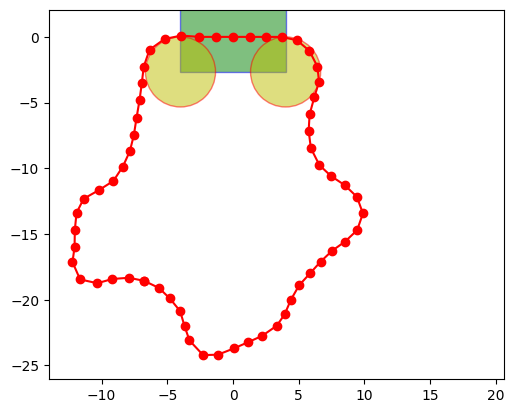

In [22]:
addMass = False
addResistance = False
topFixed = False
periodic = True
initialConition = "square"


N = 60
m_point = 1
k = 5000
k2 = 500
l = 1
g = 9.8
# high air resistance: 
# b_point = 1

# medium air resistance: 
# b_point = 0.7

# low air resistance: 
b_point = 0.1

Lbox = 8
vmax = 50
w0 = 2 * (2 * np.pi * vmax / Lbox)
# Wbox = 5 * N * g * l / Lbox / w0 ** 2
Wbox = Lbox / 3
kc = m_point * w0 ** 2 * 10
bc = 2 * np.sqrt(kc * m_point)
v = 5
b = np.ones(N) * b_point
m = np.ones(N) * m_point
x_init, p_init = initialize(N, v, m, N * l / 4)
bthrower=20
Rc = Wbox

x_all = [x_init]
p_all = [p_init]

# evolve array with time
t_f = 5
dt = 0.001

t = 0
x = x_init
p = p_init

while t < t_f:
    xnext, pnext = symplectic_euler(x, p, m, dt)
    x = xnext
    p = pnext
    x_all.append(x)
    p_all.append(p)
    t += dt

x_to_animate = x_all[::10]
if periodic == True:
    x_to_animate = [np.concatenate((x_to_animate[i],[x_to_animate[i][0]]),axis=0) for i in range(len(x_to_animate))]

animate_structured_array(x_to_animate, filename = 'low_air_resistance.gif')